In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import l1_loss
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np

In [2]:
## merge
# 1. calculate rho over the entire dataset seen so far
def calculate_rho(data, w, phi, sigma):
    h=torch.vstack([dist.MultivariateNormal(_phi, sigma).log_prob(data) for _phi in phi])
    log_weights = torch.log(w) + h.T # Compute log of weights * likelihood
    log_rho = log_weights - torch.logsumexp(log_weights, dim=1, keepdim=True)  # Normalize
    return torch.exp(log_rho).squeeze()

# 2. calculate cluster similarity
def calculate_cluster_similarity(rho, K):
    ## TODO: make similarity metric an arg?
    return (
        torch.tensor(
            [l1_loss(rho[:,i], rho[:,j], reduction='mean') if j > i else 0. 
            for i in range(K) for j in range(K)]
        )
        .view(K, K)
    )

# 3. identify those clusters to merge
def get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold):
    mask = (cluster_similarity_matrix > 0) & (cluster_similarity_matrix < similarity_threshold)
    to_merge = torch.nonzero(mask, as_tuple=False)
    values_to_merge = cluster_similarity_matrix[mask]
    order = torch.argsort(values_to_merge, descending=False) # order clusters in order of most similar
    return to_merge[order]

# 4. calculate merge statistics
def get_merge_statistics(clusters_to_merge, phi, rho, K):
    merged = []
    all_to_prune = []
    merge_statistics = dict()

    for m in clusters_to_merge:
        if (m[0] not in merged) and (m[1] not in merged):
            all_to_prune.append(m[0].item()) # prune first idx
            # use second idx as update
            merge_statistics[m[1].item()] = {
                'phi': (phi[m[0]] + phi[m[1]]) / 2,
                'rho': rho[m[0]] + rho[m[1]]
            }
            merged.append(m[0])
            merged.append(m[1])
    
    # convert to boolean tensor
    all_to_prune = torch.tensor([i in all_to_prune for i in range(K)])
    return merge_statistics, all_to_prune

## apply merge, then apply prune
def apply_merge(merge_statistics, phi, w):
    phi = phi.detach() ## remove from computation graph temporarily
    for k, v in merge_statistics.items():
        phi[k] = v['phi']
        w[k] = v['rho']
    phi = phi.requires_grad_(True) # reattach to graph
    return phi, w

def prune(prune_idx: torch.Tensor, w: torch.Tensor, phi: torch.Tensor):
    w = w[~prune_idx]
    phi = phi[~prune_idx]
    K = w.size(0)
    return w, phi, K

def merge_and_prune(data, w, phi, rho, sigma, K, similarity_threshold):
    rho_prime = calculate_rho(data, w, phi, sigma)
    cluster_similarity_matrix = calculate_cluster_similarity(rho_prime, K)
    clusters_to_merge = get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold)
    merge_statistics, all_to_prune = get_merge_statistics(clusters_to_merge, phi, rho, K)
    phi, w = apply_merge(merge_statistics, phi, w)
    w, phi, K = prune(all_to_prune, w, phi)
    return w, phi, K

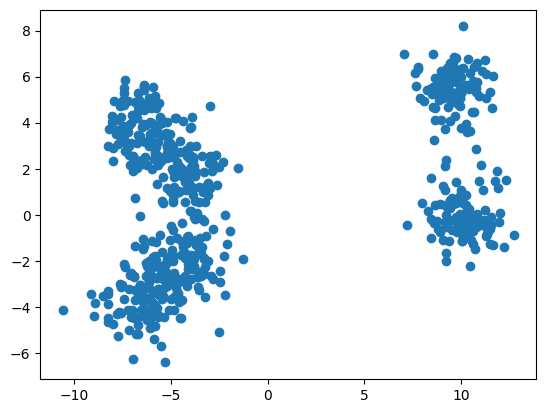

In [4]:
clusters = [
    dist.MultivariateNormal(
        torch.tensor([10*torch.cos(torch.tensor(i/.5)), 10*torch.sin(torch.tensor(i/.3))]),
        torch.diag(torch.ones(2,))
    ) for i in range(-3, 3)
]
N = 100
raw_data = torch.stack([
    d.sample(torch.tensor([N])) for d in clusters
]).reshape(-1, 2) 

data = raw_data.detach().numpy()
plt.scatter(
    data[:,0],
    data[:, 1]
)

In [5]:
n = raw_data.size(0)
lr = 1.0e-2
eps_new = .99

## pruning
eps_prune = .01
prune_freq = 100

## merging
eps_merge = .1
# merge_freq = 1000

K = 1
rho = torch.tensor([1.])
w = torch.tensor([1.])
alpha = torch.tensor([1.])
## set up base dist (mu of theta)
sigma = torch.diag(torch.ones(2,))
mu0 = torch.zeros((2,))
base_dist = dist.MultivariateNormal(mu0, 10*torch.diag(torch.ones(2,)))

## create first phi
phi = torch.nn.Parameter(raw_data[0,:])

## shuffle data
shuffdex = np.array(range(n))
np.random.shuffle(shuffdex)
data = raw_data[shuffdex,:]

for idx, i in enumerate(data[1:,:]):

    if (idx+1) % prune_freq == 0:
        to_prune = (w / w.sum()) < eps_prune
        prune_w = w[to_prune]
        prune_phi = phi[to_prune]
        print(
            f"Pruning at {idx + 1}...", 
            f"W:= {prune_w}",
            f"phi:= {prune_phi}",
            sep='\n'
        )
        w, phi, K = prune(to_prune, w, phi)
        w, phi, K = merge_and_prune(data[:idx], w, phi, rho, sigma, K, eps_merge)
        print(f"merged at {idx+1}: phi: {phi}, K: {K}")





    new_phi = torch.nn.Parameter(base_dist.sample())
    _phi = torch.vstack((phi, new_phi))
    _w = torch.concat((w, alpha))

    rho = calculate_rho(i, _w, _phi, sigma)



    if rho[K] > eps_new:
        # w is sum of rho across all previous obs
        w += rho[:K]
        w_next = torch.tensor([rho[K]])
        w = torch.concat((w, w_next))

        # add new params
        phi = torch.vstack((phi, new_phi))
        K += 1
        print(f"Increasing clusters to {K} at obs {idx}, located at: {new_phi}...")

    else:
        # renormalise to exclude K+1
        rho = rho[:K] / rho[:K].sum()

        # w is sum of rho across all previous obs
        w += rho[:K]

    to_update = (rho.detach()*(base_dist.log_prob(phi) + dist.MultivariateNormal(phi, sigma).log_prob(i))).mean()

        
    grad_phi = torch.autograd.grad(to_update, phi,  retain_graph=True)[0]  # Compute gradient manually
    phi = phi + lr * grad_phi  # Apply gradient update
    phi = phi.detach().requires_grad_(True)  # Detach to prevent old computation graph accumulation






Increasing clusters to 2 at obs 1, located at: Parameter containing:
tensor([-2.4128, -3.6949], requires_grad=True)...
Increasing clusters to 3 at obs 9, located at: Parameter containing:
tensor([-1.4153, -0.4392], requires_grad=True)...
Increasing clusters to 4 at obs 26, located at: Parameter containing:
tensor([-3.6988,  1.4961], requires_grad=True)...
Pruning at 100...
W:= tensor([], grad_fn=<IndexBackward0>)
phi:= tensor([], size=(0, 2), grad_fn=<IndexBackward0>)
merged at 100: phi: tensor([[ 8.8666,  4.6578],
        [-2.6855, -3.5057],
        [-1.5022, -0.3708],
        [-3.7916,  1.5542]], grad_fn=<IndexBackward0>), K: 4
Pruning at 200...
W:= tensor([], grad_fn=<IndexBackward0>)
phi:= tensor([], size=(0, 2), grad_fn=<IndexBackward0>)
merged at 200: phi: tensor([[ 8.8583,  4.4516],
        [-2.8521, -3.4842],
        [-1.5059, -0.3716],
        [-3.9009,  1.6048]], grad_fn=<IndexBackward0>), K: 4
Pruning at 300...
W:= tensor([], grad_fn=<IndexBackward0>)
phi:= tensor([], size=(

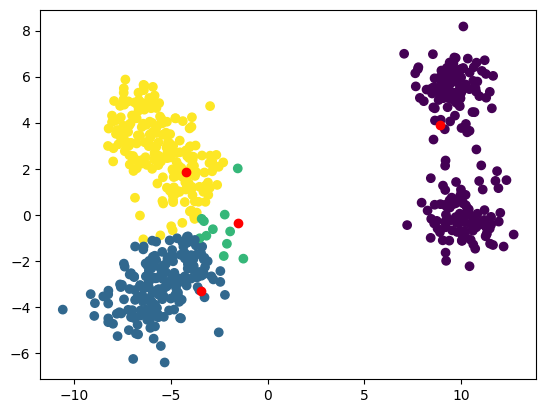

In [ ]:
phi_np = phi.detach().numpy()

clusters = torch.argmax(
    torch.exp(dist.MultivariateNormal(phi, sigma).log_prob(data.unsqueeze(1)) ), 
    axis=1).detach().numpy()

k = data.detach().numpy()
plt.scatter(
    k[:,0], k[:,1],
    label='data',
    c = clusters
)
plt.scatter(
    phi_np[:,0],
    phi_np[:,1],
    label='means',
    c='red'
    # alpha = rho.detach().numpy()
)

plt.legend()

In [2]:
dist.Exponential(scale=1, loc=1)

TypeError: Exponential.__init__() got an unexpected keyword argument 'scale'